In [1]:
import sys
sys.path.append('../..')

In [2]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns
import torch.nn.functional as F

/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "serif"
})
plt.rcParams.update({
    'text.latex.preamble':r"\usepackage{amsmath}"+"\n"+r"\usepackage{bm}"
})

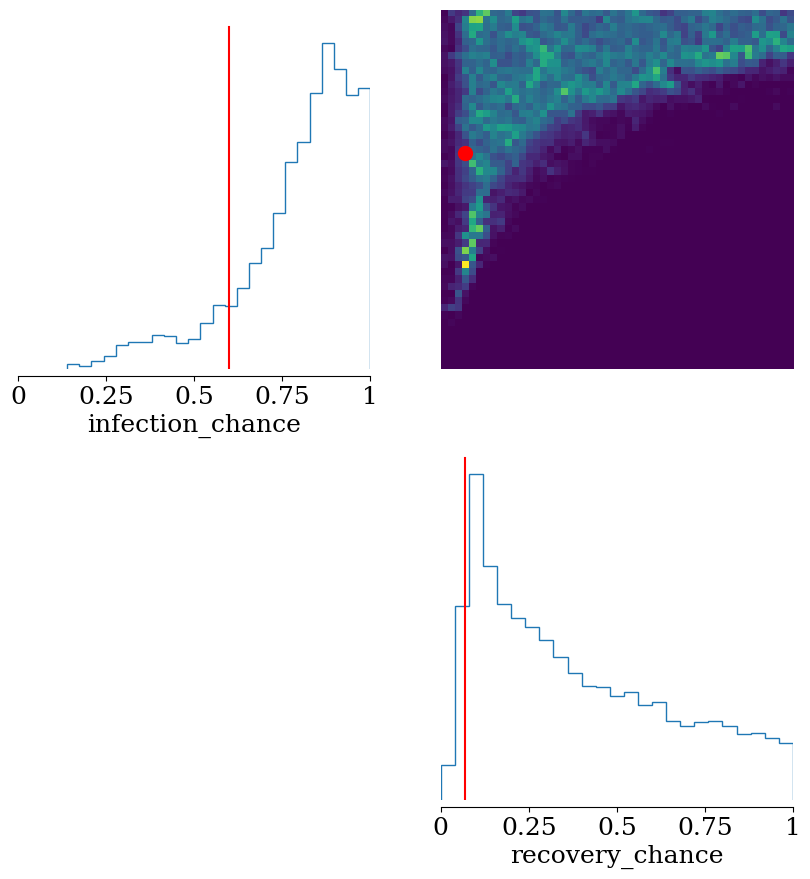

In [10]:
virus = np.loadtxt("../../exp_dir/virus/resnet_100000/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(virus, limits=[[0,1], [0,1]], points=[np.array([0.6, 0.07])],
                      points_colors='r', labels=["infection_chance", "recovery_chance"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


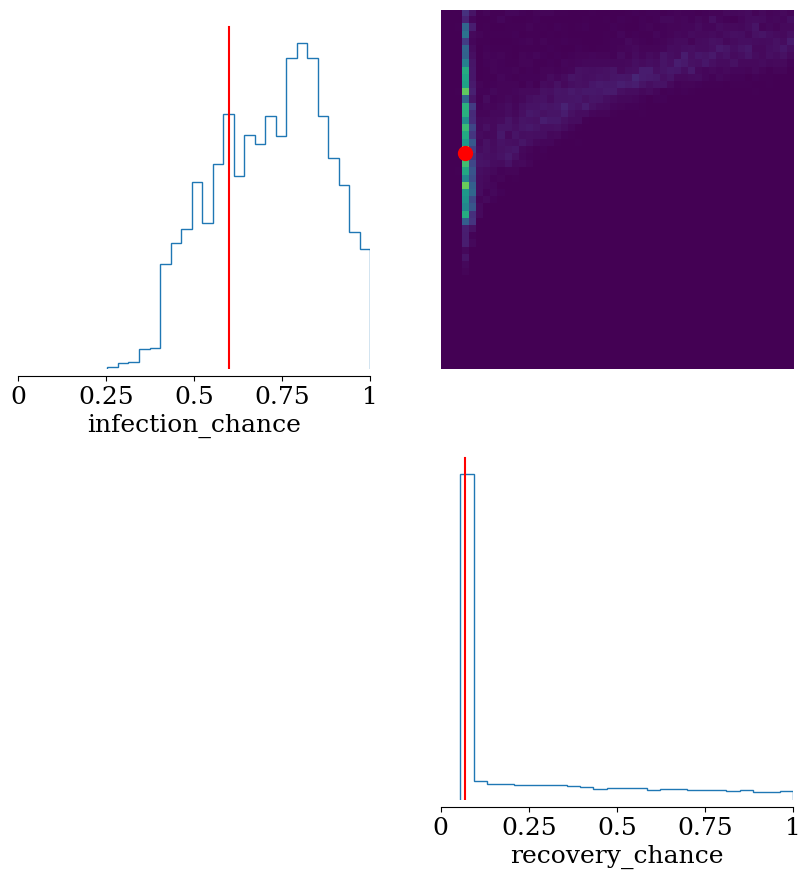

In [9]:
# new architecture (resnet)
virus = np.loadtxt("../../exp_dir/virus/1714602138.446468/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(virus, limits=[[0,1], [0,1]], points=[np.array([0.6, 0.07])],
                      points_colors='r', labels=["infection_chance", "recovery_chance"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


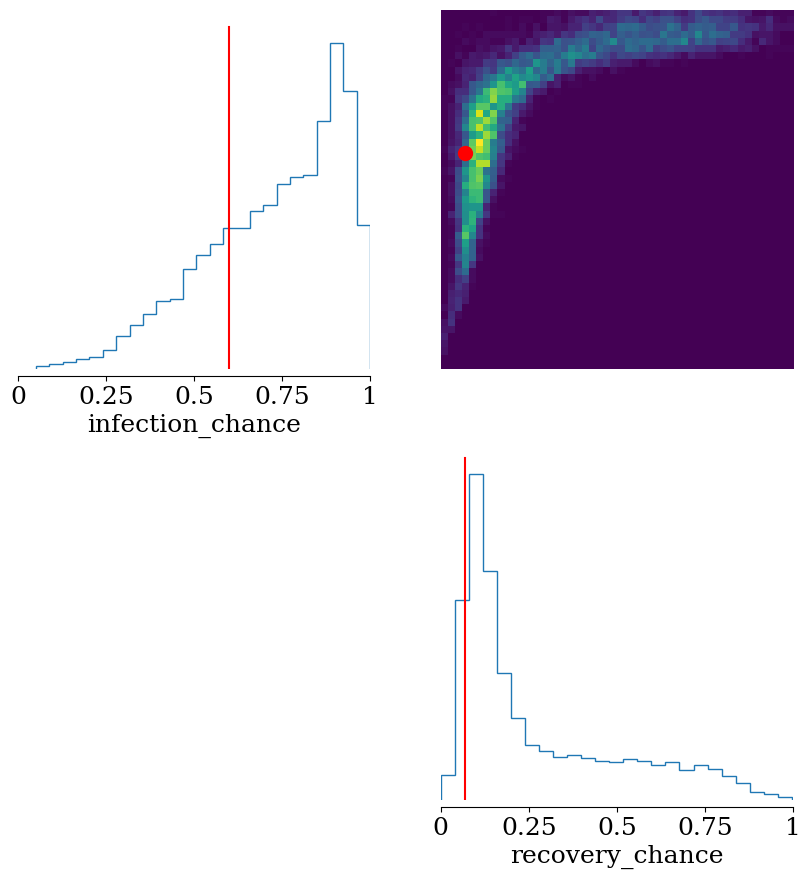

In [17]:
virus = np.loadtxt("../../exp_dir/virus/maf_100000/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(virus, limits=[[0,1], [0,1]], points=[np.array([0.6, 0.07])],
                      points_colors='r', labels=["infection_chance", "recovery_chance"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

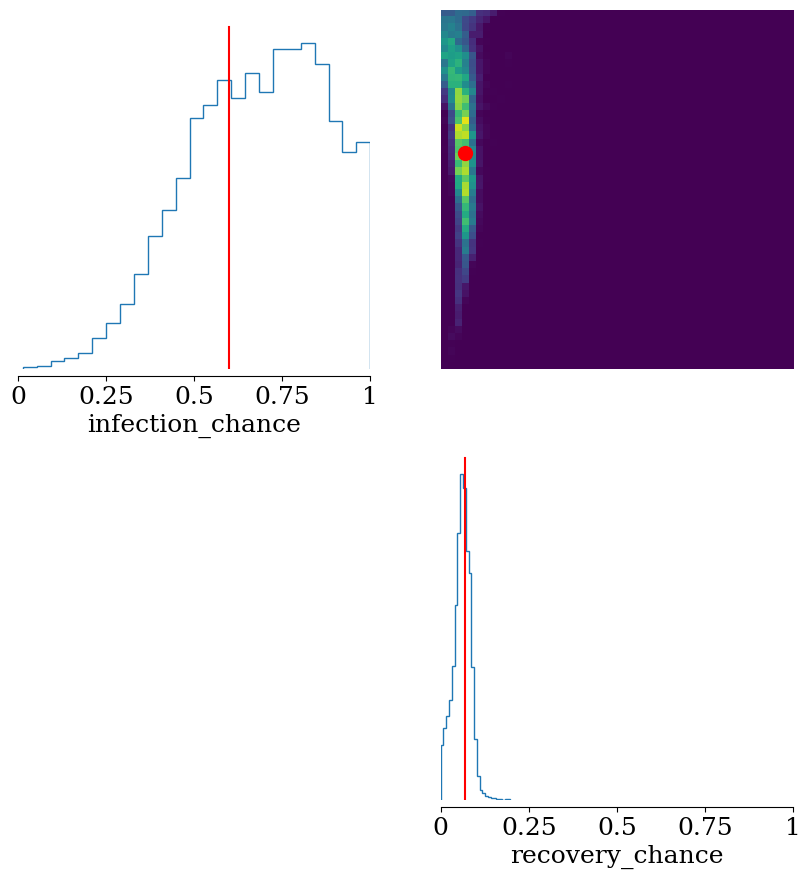

In [4]:
# maf new arch final
virus = np.loadtxt("../../exp_dir/virus/1715959663.198375/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(virus, limits=[[0,1], [0,1]], points=[np.array([0.6, 0.07])],
                      points_colors='r', labels=["infection_chance", "recovery_chance"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


# MAP

In [9]:
from sbi4abm.utils import io

virusf = io.load_task('virus')

file_name = "1715959663.198375"
with open(f"../../exp_dir/virus/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [10]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()

In [11]:
from scipy.optimize import minimize

# observed data
final = virusf[2][-1]
observation_infected = final[1]
observation_recovered = final[2]
observations = torch.tensor([observation_infected, observation_recovered])
print(observations)

initial_theta = virusf[1].mean.numpy()

# Optimize to find the MAP estimate
result = minimize(neg_log_posterior, initial_theta, args=(posterior, observations), method='L-BFGS-B')
map_estimate = result.x

print(f"MAP estimate: {map_estimate}")

tensor([0.0010, 0.9990], dtype=torch.float64)
MAP estimate: [0.5 0.5]


In [12]:
true_theta = torch.tensor([virusf[3]])
mean_theta = torch.tensor([map_estimate])
print(true_theta)
print(map_estimate)
loss = F.mse_loss(mean_theta, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([[0.6000, 0.0700]], dtype=torch.float64)
[0.5 0.5]
Loss between mean theta and true theta: 0.09744999999999998


/tmp/ipykernel_2244833/4088276064.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  true_theta = torch.tensor([virusf[3]])


In [13]:
y_star = virusf[0](map_estimate)
y_star = torch.tensor([y_star[-1][1], y_star[-1][2]])
print(y_star)

THETAs:  {'steps': 100, 'infection_chance': 0.5, 'recovery_chance': 0.5}
Completed: 100 steps
Run time: 0:00:00.519786
Simulation finished
(101, 3)
tensor([0.0000, 0.9698], dtype=torch.float64)


In [14]:
import torch.nn.functional as F

def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)

print(observations)
print(y_star)

# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss between s(y_star) and s(y): {loss.item()}")

tensor([0.0010, 0.9990], dtype=torch.float64)
tensor([0.0000, 0.9698], dtype=torch.float64)
Loss between s(y_star) and s(y): 0.00042828124999999995


# Mean

In [15]:
# Generate samples from the posterior
num_samples = 1000  # Number of samples to draw
posterior_samples = posterior.sample((num_samples,), x=observations)

# Compute the mean of the samples
mean_estimate = posterior_samples.mean(dim=0)
print(f"Mean estimate: {mean_estimate}")

Drawing 1000 posterior samples: 8884it [00:00, 44256.65it/s]            

Mean estimate: tensor([0.6707, 0.0600])


In [16]:
# Compute statistics about the sampled theta values
posterior_samples_np = posterior_samples.numpy()
mean_theta = np.mean(posterior_samples_np, axis=0)
std_theta = np.std(posterior_samples_np, axis=0)
lower_bound_theta = np.percentile(posterior_samples_np, 2.5, axis=0)
upper_bound_theta = np.percentile(posterior_samples_np, 97.5, axis=0)

print(f"Mean of theta: {mean_theta}")
print(f"Standard deviation of theta: {std_theta}")
print(f"95% credible interval for theta: [{lower_bound_theta}, {upper_bound_theta}]")

Mean of theta: [0.670672   0.06004515]
Standard deviation of theta: [0.19920662 0.02494388]
95% credible interval for theta: [[0.26310633 0.00867709], [0.98132415 0.10415432]]


In [17]:
true_theta = torch.tensor([virusf[3]])
mean_theta = torch.tensor([mean_theta])
print(true_theta)
print(mean_theta)
loss = F.mse_loss(mean_theta, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([[0.6000, 0.0700]], dtype=torch.float64)
tensor([[0.6707, 0.0600]])
Loss between mean theta and true theta: 0.0025468152808992826


In [18]:
y_star = virusf[0](mean_estimate)
y_star = torch.tensor([y_star[-1][1], y_star[-1][2]])

print(y_star)
print(observations)

THETAs:  {'steps': 100, 'infection_chance': 0.6706719398498535, 'recovery_chance': 0.06004517525434494}
Completed: 100 steps
Run time: 0:00:00.569014
Simulation finished
(101, 3)
tensor([0.0037, 0.9962], dtype=torch.float64)
tensor([0.0010, 0.9990], dtype=torch.float64)


In [19]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss: {loss.item()}")

Loss: 7.562500000000082e-06


# Posterior Predictive Checks 

In [30]:
from sbi4abm.utils import io

virusf = io.load_task('virus')

In [31]:
idxs = np.random.randint(virus.shape[0], size=1000)

### Posterior Predictives

In [32]:
pps = []
for idx in idxs:
    data = virusf[0](list(virus[idx]))
    pps.append(data)

THETAs:  {'steps': 100, 'infection_chance': 0.3087841868400574, 'recovery_chance': 0.06375952810049057}
Completed: 100 steps
Run time: 0:00:00.713023
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.8240026831626892, 'recovery_chance': 0.02313474752008915}
Completed: 100 steps
Run time: 0:00:00.996942
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.6488780975341797, 'recovery_chance': 0.09777939319610596}
Completed: 100 steps
Run time: 0:00:00.529834
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.5672786235809326, 'recovery_chance': 0.06149701029062271}
Completed: 100 steps
Run time: 0:00:00.604425
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.9847186207771301, 'recovery_chance': 0.00448575709015131}
Completed: 100 steps
Run time: 0:00:01.555043
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.5701810717582703, 'recovery_chance': 0.07484111934900284}
C

In [35]:
posterior_infected = []
posterior_recovered = []

for pp in pps:
    final_state = pp[-1]
    posterior_infected.append(final_state[1])
    posterior_recovered.append(final_state[2])

### Prior Predictives

In [36]:
pps_ = []
for idx in idxs:
    data = virusf[0](list(virusf[1].sample().tolist()))
    pps_.append(data)

THETAs:  {'steps': 100, 'infection_chance': 0.17564105987548828, 'recovery_chance': 0.804167628288269}
Completed: 100 steps
Run time: 0:00:00.565053
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.5912544131278992, 'recovery_chance': 0.22214841842651367}
Completed: 100 steps
Run time: 0:00:00.364517
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.27634942531585693, 'recovery_chance': 0.32986098527908325}
Completed: 100 steps
Run time: 0:00:00.343044
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.5183095335960388, 'recovery_chance': 0.1816009283065796}
Completed: 100 steps
Run time: 0:00:00.371399
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.8994882702827454, 'recovery_chance': 0.8117363452911377}
Completed: 100 steps
Run time: 0:00:00.313899
Simulation finished
(101, 3)
THETAs:  {'steps': 100, 'infection_chance': 0.3033689856529236, 'recovery_chance': 0.3884761333465576}
Comp

In [37]:
prior_infected = []
prior_recovered = []

for pp in pps_:
    final_state = pp[-1]
    prior_infected.append(final_state[1])
    prior_recovered.append(final_state[2])

### Observation

In [38]:
final = virusf[2][-1]
observation_infected = final[1]
observation_recovered = final[2]

### Plots

In [39]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

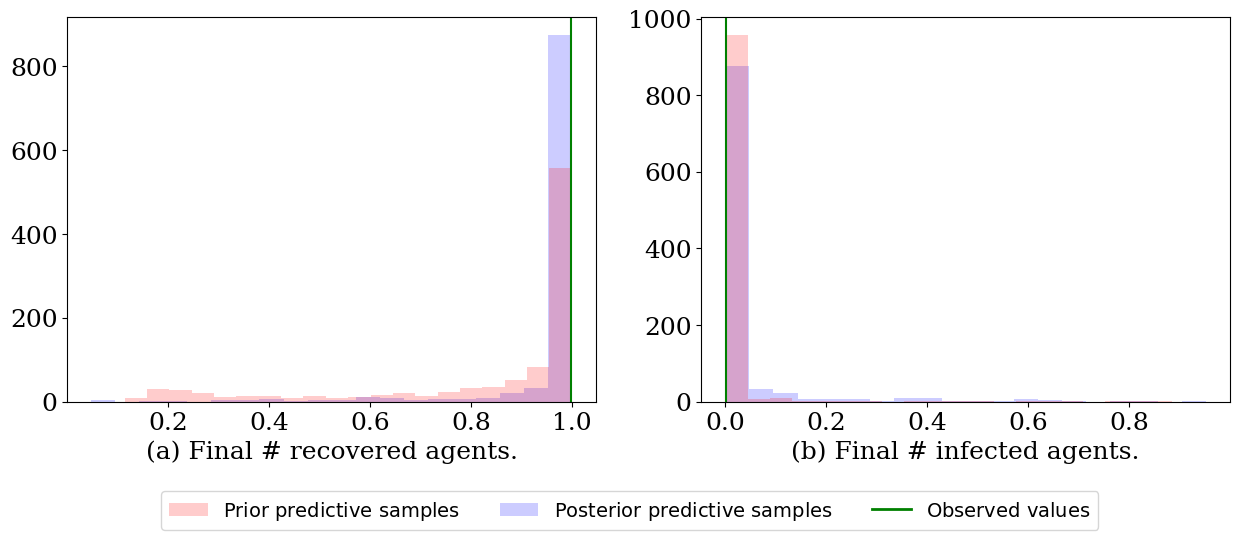

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(posterior_recovered, bins=20, color='b', alpha=0.2)
axes[0].hist(prior_recovered, bins=20, color='r', alpha=0.2)
axes[0].axvline(observation_recovered, c='g')
axes[0].set_xlabel(r"(a) Final # recovered agents.", fontsize=18)

axes[1].hist(posterior_infected, bins=20, color='b', alpha=0.2)
axes[1].hist(prior_infected, bins=20, color='r', alpha=0.2)
axes[1].axvline(observation_infected, c='g')
axes[1].set_xlabel(r"(b) Final # infected agents.", fontsize=18)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

# fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18)
fig.legend(handles=handles, bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3, fontsize=14)

# plt.savefig("./overleaf_plots/graph_posterior_predictives.png", dpi=1000, format='png', bbox_inches='tight')

# Sensitivity Analysis

In [15]:
file_name = "maf_100000"
with open(f"../../exp_dir/virus/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

Drawing 200 posterior samples: 9998it [00:00, 48006.02it/s]           


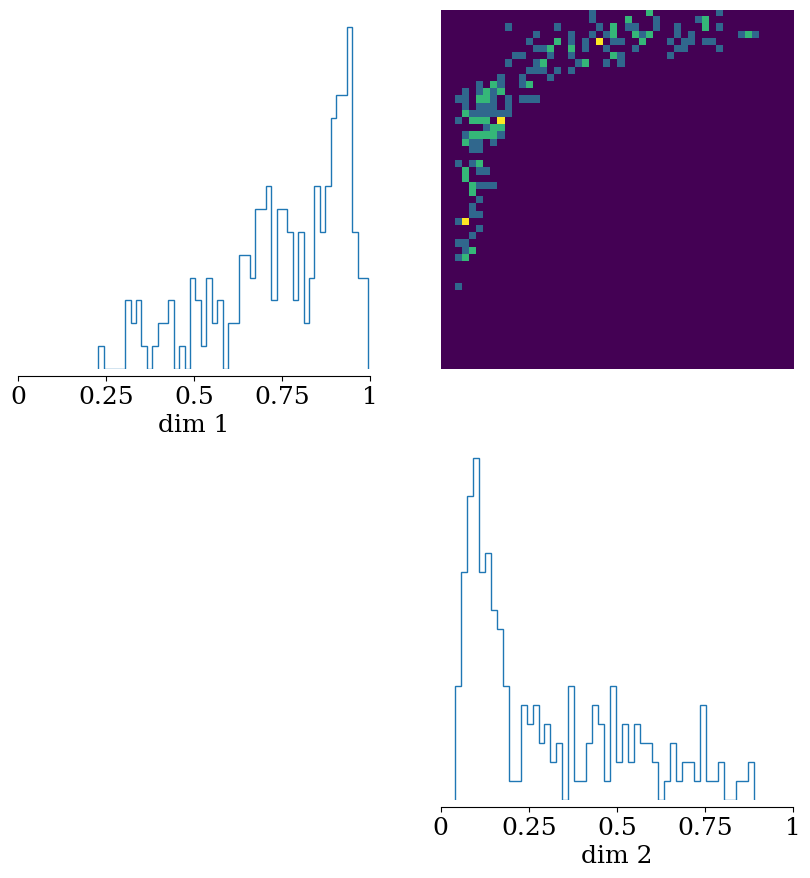

In [16]:
from sbi4abm.sbi.analysis import ActiveSubspace, pairplot

posterior_samples = posterior.sample((200,))
_ = pairplot(posterior_samples, limits=[[0,1], [0,1]], figsize=(10, 10))

In [18]:
sensitivity = ActiveSubspace(posterior)
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Drawing 1000 posterior samples: 10809it [00:00, 38305.33it/s]           


Eigenvalues: 
 tensor([2.5243e-05, 8.0119e-05]) 

Eigenvectors: 
 tensor([[ 0.9129,  0.4082],
        [ 0.4082, -0.9129]])
